Import libraries here

In [1]:
import numpy as np
import scipy as sp
import csv
import bisect
import random
import scipy.interpolate as interp
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
import george
from george.kernels import CosineKernel,ExpSquaredKernel

import matplotlib.pyplot as plt
%matplotlib inline

#import george
#from george.kernels import ExpSquaredKernel

Establish sensible redshifts

In [3]:
n_zs = 1.e2
lya = 1215.67
minlambda = 3650
logminlambda = np.log10(minlambda)
maxlambda = 10400
logmaxlambda = np.log10(maxlambda)
res = (logmaxlambda-logminlambda)/n_zs
loglambdas = np.arange(logminlambda,logmaxlambda,res)
lambdas = 10**(loglambdas)
def zsolve(l):
    z = (l-lya)/l
    return z
zs = np.array([zsolve(l) for l in lambdas])
minz = min(zs)
maxz = max(zs)
zrange = maxz-minz

Establish true overdensity field

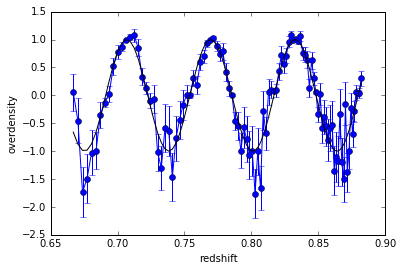

In [17]:
frequency = 100.

deltath = np.sin(zs*frequency)
errconst = 0.1*(max(deltath)-deltath)

deltaerr = np.sqrt(errconst*np.abs(deltath))
delta = deltath + deltaerr * np.random.randn(len(zs))
plt.plot(zs,delta,'bo')
plt.errorbar(zs, delta, deltaerr, color='b', markersize=10)#, fmt='k.', markersize=10, label=u'Observations',
                 #ecolor='gray')
plt.plot(zs,deltath,c='k')
plt.xlabel('redshift')
plt.ylabel('overdensity')

GP fit to true overdensity field

/Users/aimalz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: covariance is not positive-semidefinite.


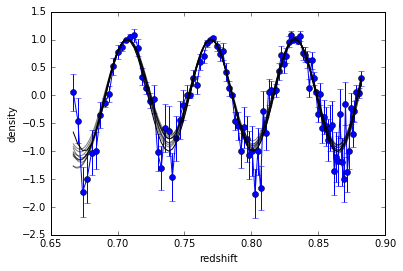

In [39]:
kernel_param = 0.001
kernel = ExpSquaredKernel(kernel_param)#chosen by magic

gp = george.GP(kernel)

gp.compute(zs, deltaerr)

ztest = np.linspace(min(zs), max(zs), 500)

mu, cov = gp.predict(delta, ztest)
std = np.sqrt(np.diag(cov))

nsamps = 10
toplot = np.random.multivariate_normal(mu,cov,nsamps)
plt.plot(zs,delta,'bo')
plt.errorbar(zs, delta, deltaerr, color='b')
for s in xrange(nsamps):
    plt.plot(ztest,toplot[s],c='k',alpha=5./nsamps)
plt.plot(zs,deltath,c='k')
plt.xlabel('redshift')
plt.ylabel('density')

Generate probabilities of being Lyman alpha for each line

In [40]:
pop_frac = 0.5#fraction of Ly-a lines expected

norm_delta_err = np.array([min((delta[n]+1.)/2.,1.) for n in xrange(len(delta))])
norm_delta_err = np.array([max(norm_delta_err[n]*(1.-pop_frac),0.) for n in xrange(len(delta))])

def make_one_prob(err):
    p = err*np.random.rand(1)
    return p
def make_probs(deltaerr):
    N = len(deltaerr)
    ps = [make_one_prob(deltaerr[n]) for n in xrange(N)]
    return ps

npix = len(zs)
p = make_probs(norm_delta_err)

Make catalogs of survey instantiations

(100, 100)


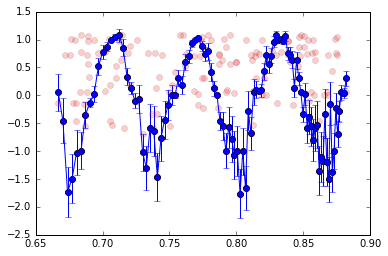

In [41]:
def add_one_to_cat(y,xt,p):
    if np.random.uniform() > p:
        return xt
    return minz+zrange*np.random.rand(1)#or bias this
def make_cat(ys,xts,ps):
    output = []
    for n in xrange(len(ps)):
        output.append(add_one_to_cat(ys[n],xts[n],ps[n]))
    return np.array(output)

ncats = 10
obszs = [make_cat(delta,zs,p) for n in xrange(ncats)]

print(len(obszs[0]),len(zs))
for xo in obszs:
    plt.plot(xo,delta,'ro',alpha=1./5.)
    #plt.errorbar(xo, delta, deltaerr, color='r', markersize=10)
plt.plot(zs,delta,'bo')
plt.errorbar(zs, delta, deltaerr, color='b')
plt.savefig('instantiation.png')

Fit GP to instantiations of catalog

In [42]:
gp_obss = [george.GP(kernel) for c in range(ncats)]

mu_obss,cov_obss,std_obss = [],[],[]
for c in range(ncats):
    gp_obss[c].compute(obszs[c], deltaerr)
    mu, cov = gp_obss[c].predict(delta, ztest)
    std = np.sqrt(np.diag(cov))
    mu_obss.append(mu)
    cov_obss.append(cov)
    std_obss.append(std)

Plot the results!

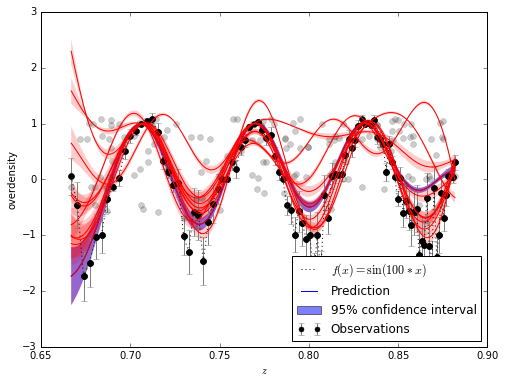

In [43]:
x_pred = ztest
y_pred = mu
sigma = std
y_preds = mu_obss
sigmas = std_obss

def plot_results_all(X, y, dy, x_pred, y_pred, sigma, y_preds, sigmas):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(zs, delta, 'k:', label=u'$f(x) = \sin(100*x)$')
    plt.errorbar(X.ravel(), y, dy, fmt='k.', markersize=10, label=u'Observations',
                 ecolor='gray')
    plt.plot(x_pred, y_pred, 'b-', label=u'Prediction')
    plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    for xo in obszs:
        plt.plot(xo,delta,'ko',alpha=1./5.)
    for c in xrange(ncats):
        plt.plot(x_pred, y_preds[c], 'r-',alpha=10./ncats)
        plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
             np.concatenate([y_preds[c] - 1.9600 * sigmas[c],
                            (y_preds[c] + 1.9600 * sigmas[c])[::-1]]),
             alpha=2./ncats, fc='r', ec='None')
    plt.xlabel('$z$')
    plt.ylabel('overdensity')
    plt.legend(loc='lower right');
    plt.savefig('final_results.png')
    
plot_results_all(zs, delta, deltaerr, x_pred, y_pred, sigma, y_preds, sigmas)

![badge-img](https://img.shields.io/badge/Made%20at-%23AstroHackWeek-8063d5.svg?style=flat)